## Cosine Similarity between text documents

### For 600 million cross-joined edges, we only need sqrt(600 million) = 24,495 documents as the data set size. However, we will also calculate cosine similarity on 10,000 million cross-joined edges to show performance

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import time
import json
from cachetools import cached
from time import perf_counter
from typing import Iterable, Tuple
# Snowpark Imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.functions import udf, udtf

#### Create snowpark session

In [2]:
# Reading Snowflake Connection Details
snowflake_connection_cfg = json.loads(open('snowflake-creds.json').read())
session = Session.builder.configs(snowflake_connection_cfg).create()

#### Create snowflake stage to persist UDFs and UDTFs

In [3]:
session.sql("create stage if not exists FUNCTIONS").collect()

[Row(status='FUNCTIONS already exists, statement succeeded.')]

#### View the data

In [4]:
original_texts_df = session.table('SAMPLE_TEXTS')
original_texts_df.show()

------------------------------------------------------------------
|"TEXT_ID"  |"TEXT"                                              |
------------------------------------------------------------------
|0          |Snowflake Inc. is a cloud computing–based data ...  |
|1          |Netflix, Inc. is an American media company base...  |
|2          |Avatar is an American media franchise created b...  |
|3          |In data analysis, cosine similarity is a measur...  |
|4          |Avatar is an American media franchise created b...  |
|5          |In data analysis, cosine similarity is a measur...  |
|6          |Netflix, Inc. is an American media company base...  |
|7          |Avatar is an American media franchise created b...  |
|8          |Avatar is an American media franchise created b...  |
|9          |Avatar is an American media franchise created b...  |
------------------------------------------------------------------



In [5]:
original_texts_df.count()

100000

#### Start with small warehouse to register UDFs and UDTFs

In [6]:
session.sql(f"ALTER WAREHOUSE {session.get_current_warehouse()} set WAREHOUSE_SIZE=SMALL").collect()

[Row(status='Statement executed successfully.')]

#### Register UDF for extracting feature vectors

In [7]:
@cached(cache={})
def f_load_spacy_model()-> object:
    import spacy
    import en_core_web_sm
    nlp = en_core_web_sm.load()
    # As we're only interested in vectors we can disable other parts of the pipeline
    nlp.disable_pipes('parser','attribute_ruler','lemmatizer','ner')
    return nlp

# User-Defined-Function that extracts feature vector from text
@udf(name='f_spacy_vectorizer', 
     session=session,
     input_types=[T.StringType()], 
     return_type=T.BinaryType(), 
     is_permanent=True, 
     replace=True, 
     stage_location='@FUNCTIONS', 
     max_batch_size=1000, 
     packages=['spacy==3.3.0','spacy-model-en_core_web_sm','cachetools'])
def f_spacy_vectorizer(text_series: pd.Series) -> pd.Series:
    nlp = f_load_spacy_model()
    docs = []
    # Spacy's pipe interface is optimized for batched input
    for doc in nlp.pipe(text_series, batch_size=1000, n_process=1):
        docs.append(doc.vector.tobytes()) # vector is converted to bytes
    return docs

package spacy-model-en_core_web_sm is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.


#### Register UDTF for cosine similarity calculation

In [8]:
# UDTF to calculate cosine-similarity on batched rows (bytearrays)
@udtf(name="f_cosine_similarity",
     is_permanent=True, 
     stage_location='@FUNCTIONS', 
     output_schema=['TEXT_ID_LEFT','TEXT_ID_RIGHT','COSINE_SIMILARITY'],
     replace=True, 
     packages=['scikit-learn','numpy'], 
     session=session)
class f_cosine_similarity:
    def process(self, id_vec1: list, id_vec2: list) -> Iterable[Tuple[str,str,float]]:
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        import itertools
        # Collect paths
        input1_id = [val[0] for val in id_vec1]
        input2_id = [val[0] for val in id_vec2]
        
        # Collect vectors (need to convert strings to bytes)
        input1_calc = np.array([np.frombuffer(bytes(val[1], 'utf-8'), dtype=np.float32) for val in id_vec1])
        input2_calc = np.array([np.frombuffer(bytes(val[1], 'utf-8'), dtype=np.float32) for val in id_vec2])
        
        # Calculate Similarity
        # As we have to calculate cos-sim between m*n input-samples, we need pairwise calculation 
        similarities = cosine_similarity(input1_calc, input2_calc).flatten()
        
        # Transform results into list of tuples
        return [pair + (sim_value,) for pair,sim_value in zip(list(itertools.product(input1_id,input2_id)),similarities)]

package scikit-learn is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.


### For 600 million cross-joined edges, we only need sqrt(600 million) = 24,495 documents as the data set size and a XL warehouse

In [9]:
texts_df = original_texts_df.limit(24495)
session.sql(f"ALTER WAREHOUSE {session.get_current_warehouse()} set WAREHOUSE_SIZE=XLARGE").collect()

[Row(status='Statement executed successfully.')]

#### Explicitly turn off result set caching (we don’t want cache to skew performance results - in production you’d like have caching enabled and potentially that gives you a boost in performance)

In [10]:
session.sql("ALTER SESSION SET USE_CACHED_RESULT=FALSE").collect()

[Row(status='Statement executed successfully.')]

#### Extract feature vectors

In [11]:
start = perf_counter()
feature_vectors_df = texts_df.with_column('FEATURE_VECTOR', f_spacy_vectorizer('TEXT')).order_by(F.random())
feature_vectors_df.write.save_as_table('SAMPLE_TEXTS_VECTORS', mode='overwrite')
feature_vectors_df = session.table('SAMPLE_TEXTS_VECTORS')
runtime = perf_counter()-start
print('Runtime (s):', round(runtime))
print('Texts/second:', round(texts_df.count()/runtime))

Runtime (s): 35
Texts/second: 703


In [12]:
feature_vectors_df.show()

-----------------------------------------------------------------------------------------------------------------------
|"TEXT_ID"  |"TEXT"                                              |"FEATURE_VECTOR"                                    |
-----------------------------------------------------------------------------------------------------------------------
|85950      |Netflix, Inc. is an American media company base...  |bytearray(b'=E\xb5>">Q;\xef\x16\x8e\xba\xa3&4\x...  |
|56221      |Avatar is an American media franchise created b...  |bytearray(b'\x18\xc5_>m\x98=\xbe\x8f\x04`>*\x08...  |
|85762      |In data analysis, cosine similarity is a measur...  |bytearray(b"\\\xa4\xb9\xbd2\xbf&\xbe\xb1\xb2e>e...  |
|23309      |In data analysis, cosine similarity is a measur...  |bytearray(b"\\\xa4\xb9\xbd2\xbf&\xbe\xb1\xb2e>e...  |
|48736      |Avatar is an American media franchise created b...  |bytearray(b'\x18\xc5_>m\x98=\xbe\x8f\x04`>*\x08...  |
|73005      |Snowflake Inc. is a cloud c

#### Calculate cosine similarity

In [13]:
start = perf_counter()
# Aggregate feature vector table to batches
texts_per_batch = 100
num_batches = round(feature_vectors_df.count() / texts_per_batch)
batched_input = feature_vectors_df.with_column('BATCH_ID', F.uniform(1,num_batches,F.random()))
batched_input = batched_input.group_by(['BATCH_ID'])
batched_input = batched_input.agg(F.array_agg(F.array_construct('TEXT_ID','FEATURE_VECTOR')).as_('TEXT_IDS'))
# After aggregating the table we can easily cross-join with itself to calculate similarity between all texts
batched_input_results = batched_input.cross_join(batched_input, lsuffix='_LEFT', rsuffix='_RIGHT')
# evenly distribute data across nodes
batched_input_results = batched_input_results.order_by(F.random())
batched_input_results = batched_input_results.join_table_function(f_cosine_similarity('TEXT_IDS_LEFT', 'TEXT_IDS_RIGHT'))
batched_input_results = batched_input_results.drop('TEXT_IDS_RIGHT','TEXT_IDS_LEFT','BATCH_ID_RIGHT','BATCH_ID_LEFT')
batched_input_results.write.save_as_table('SAMPLE_TEXTS_VECTORS_SIM', mode='overwrite')
batched_input_results = session.table('SAMPLE_TEXTS_VECTORS_SIM')
runtime = perf_counter()-start
print('Runtime (s):', round(runtime))
print('Total Cross joined pairs:', round(batched_input_results.count()))
print('Pairs/second:', round(batched_input_results.count()/runtime))

Runtime (s): 19
Total Cross joined pairs: 600005025
Pairs/second: 32416530


### For 10,000 million cross-joined edges, we will take 100,000 documents as the data set size and a 3XL warehouse

In [14]:
texts_df = original_texts_df
session.sql(f"ALTER WAREHOUSE {session.get_current_warehouse()} set WAREHOUSE_SIZE=XXXLARGE").collect()

[Row(status='Statement executed successfully.')]

#### Explicitly turn off result set caching (we don’t want cache to skew performance results - in production you’d like have caching enabled and potentially that gives you a boost in performance)

In [15]:
session.sql("ALTER SESSION SET USE_CACHED_RESULT=FALSE").collect()

[Row(status='Statement executed successfully.')]

#### Extract feature vectors

In [16]:
start = perf_counter()
feature_vectors_df = texts_df.with_column('FEATURE_VECTOR', f_spacy_vectorizer('TEXT')).order_by(F.random())
feature_vectors_df.write.save_as_table('SAMPLE_TEXTS_VECTORS', mode='overwrite')
feature_vectors_df = session.table('SAMPLE_TEXTS_VECTORS')
runtime = perf_counter()-start
print('Runtime (s):', round(runtime))
print('Texts/second:', round(texts_df.count()/runtime))

Runtime (s): 11
Texts/second: 9463


In [17]:
feature_vectors_df.show()

-----------------------------------------------------------------------------------------------------------------------
|"TEXT_ID"  |"TEXT"                                              |"FEATURE_VECTOR"                                    |
-----------------------------------------------------------------------------------------------------------------------
|61000      |Netflix, Inc. is an American media company base...  |bytearray(b'=E\xb5>">Q;\xef\x16\x8e\xba\xa3&4\x...  |
|54781      |Snowflake Inc. is a cloud computing–based data ...  |bytearray(b'\x05N\x1e? ;\xc4<\x1el\x11>oH\x83\x...  |
|37308      |Snowflake Inc. is a cloud computing–based data ...  |bytearray(b'\x05N\x1e? ;\xc4<\x1el\x11>oH\x83\x...  |
|80608      |In data analysis, cosine similarity is a measur...  |bytearray(b"\\\xa4\xb9\xbd2\xbf&\xbe\xb1\xb2e>e...  |
|63133      |Netflix, Inc. is an American media company base...  |bytearray(b'=E\xb5>">Q;\xef\x16\x8e\xba\xa3&4\x...  |
|45705      |Snowflake Inc. is a cloud c

#### Calculate cosine similarity

In [18]:
start = perf_counter()
# Aggregate feature vector table to batches
texts_per_batch = 100
num_batches = round(feature_vectors_df.count() / texts_per_batch)
batched_input = feature_vectors_df.with_column('BATCH_ID', F.uniform(1,num_batches,F.random()))
batched_input = batched_input.group_by(['BATCH_ID'])
batched_input = batched_input.agg(F.array_agg(F.array_construct('TEXT_ID','FEATURE_VECTOR')).as_('TEXT_IDS'))
# After aggregating the table we can easily cross-join with itself to calculate similarity between all texts
batched_input_results = batched_input.cross_join(batched_input, lsuffix='_LEFT', rsuffix='_RIGHT')
# evenly distribute data across nodes
batched_input_results = batched_input_results.order_by(F.random())
batched_input_results = batched_input_results.join_table_function(f_cosine_similarity('TEXT_IDS_LEFT', 'TEXT_IDS_RIGHT'))
batched_input_results = batched_input_results.drop('TEXT_IDS_RIGHT','TEXT_IDS_LEFT','BATCH_ID_RIGHT','BATCH_ID_LEFT')
batched_input_results.write.save_as_table('SAMPLE_TEXTS_VECTORS_SIM', mode='overwrite')
batched_input_results = session.table('SAMPLE_TEXTS_VECTORS_SIM')
runtime = perf_counter()-start
print('Runtime (s):', round(runtime))
print('Total Cross joined pairs:', round(batched_input_results.count()))
print('Pairs/second:', round(batched_input_results.count()/runtime))

Runtime (s): 58
Total Cross joined pairs: 10000000000
Pairs/second: 171452104


In [19]:
batched_input_results.show()

----------------------------------------------------------
|"TEXT_ID_LEFT"  |"TEXT_ID_RIGHT"  |"COSINE_SIMILARITY"  |
----------------------------------------------------------
|20790           |8630             |0.47543761134147644  |
|20790           |41040            |0.47543761134147644  |
|20790           |51749            |0.47543761134147644  |
|20790           |26815            |0.4077727496623993   |
|20790           |92570            |0.47543761134147644  |
|20790           |54593            |0.47543761134147644  |
|20790           |81867            |0.9999999403953552   |
|20790           |86549            |0.4077727496623993   |
|20790           |85616            |0.4077727496623993   |
|20790           |65682            |0.4080118238925934   |
----------------------------------------------------------



#### Turn back result set caching on for other work down below

In [20]:
session.sql("ALTER SESSION SET USE_CACHED_RESULT=TRUE").collect()

[Row(status='Statement executed successfully.')]

In [21]:
session.sql(f"ALTER WAREHOUSE {session.get_current_warehouse()} set WAREHOUSE_SIZE=SMALL").collect()

[Row(status='Statement executed successfully.')]

#### Close snowpark session

In [22]:
session.close()

## Results

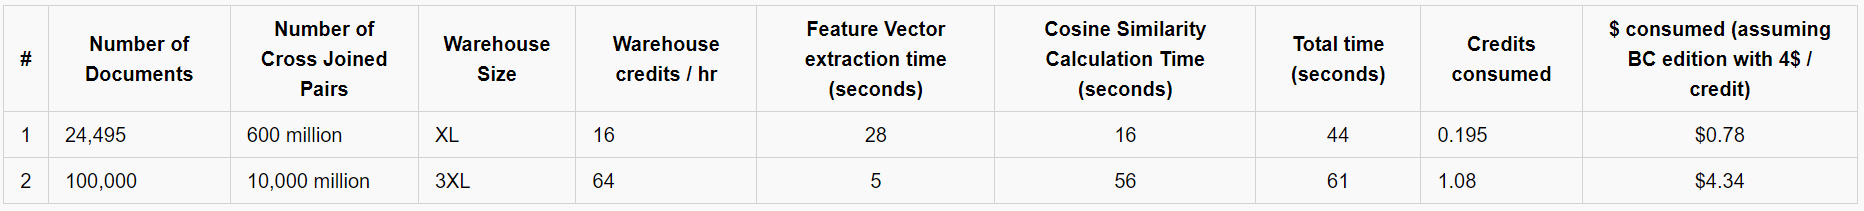